# TUIA / AAII - TP1: Redes Densas y Convoluciones - Problema 3

> *Modelo de Clasificación con CNN para clasificar imágenes en 6 categorías.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
# Importar desde Google Drive
!pip install -q gdown

In [2]:
# Datasets
import gdown
import zipfile
import os
from pathlib import Path

# Data
import numpy as np
import random

# Visualizaciones
import matplotlib.pyplot as plt
from PIL import Image
import cv2
# from matplotlib.colors import ListedColormap
# from plotly.subplots import make_subplots
# import plotly.graph_objs as go
# import seaborn as sns

# ML metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
from keras.layers import Input, Dense, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation
from keras.layers import Conv2D, Activation, GlobalMaxPooling2D, MaxPooling2D, Rescaling, Flatten, Dropout
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

### GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
* **buildings**
* **forest**
* **glacier**
* **mountain**
* **sea**
* **street**

Las imágenes están divididas en tres conjuntos:
* **Train**: Alrededor de 14,000 imágenes para entrenamiento.
* **Test**: Alrededor de 3,000 imágenes para evaluación del modelo.
* **Prediction**: Alrededor de 7,000 imágenes para predicción final.

Los modelos a

### Descarga

In [4]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=f63920fd-b1cc-4b9f-beb2-eecb44ba83f2
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:02<00:00, 125MB/s]


'TP1-3-natural-scenes.zip'

### Descompresión

In [5]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

### Carga

In [6]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("/content/TP1-3/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("/content/TP1-3/seg_test/seg_test")
TEST_DATA_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

Train y Validation

In [7]:
# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


Test

In [8]:
# Obtener la lista de nombres de archivo de las imágenes de prueba
test_image_paths = [os.path.join(TEST_DATA_DIRECTORY, filename) for filename in os.listdir(TEST_DATA_DIRECTORY)]

# Cargar las imágenes de prueba
test_images = []
for image_path in test_image_paths:
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    test_images.append(img_array)

# Convertir la lista de imágenes en un array numpy
test_images = np.array(test_images)

# El conjunto de prueba no tiene etiquetas, así que sólo están las imágenes
test_ds = tf.data.Dataset.from_tensor_slices(test_images)

## Análisis Exploratorio

In [9]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Conjuntos de Train, Val y Test

Reducimos el tamaño del dataset para emular un escenario real donde no tenemos muchos datos.

In [10]:
train_ds = train_ds.take(1000)  # Total: 14034
val_ds = val_ds.take(200)       # Total: 3000
test_ds = test_ds.take(500)     # Total: 7301

## Visualizaciones

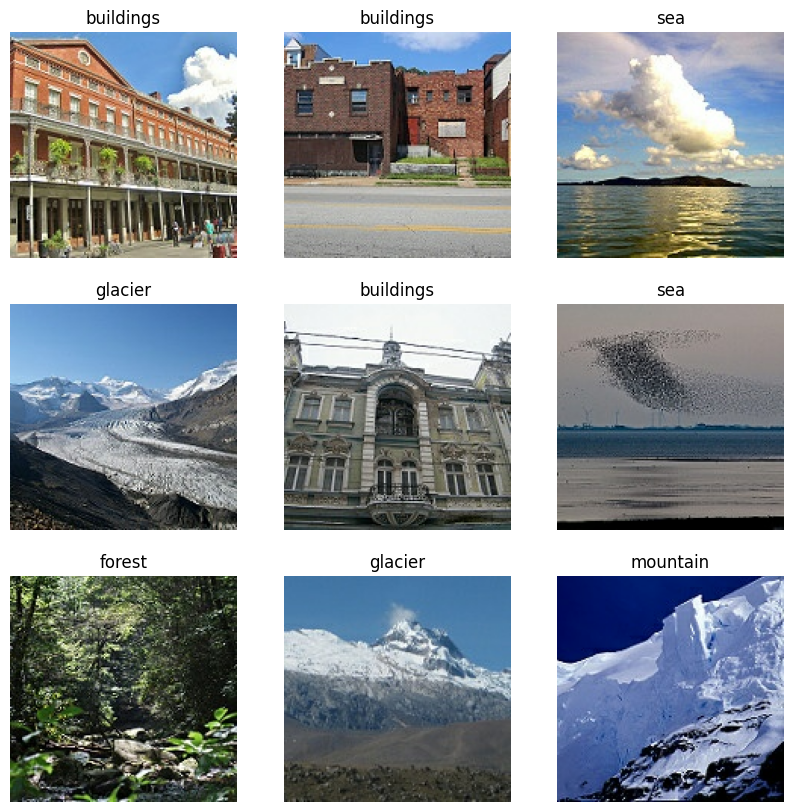

In [11]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Modelo con Capas Densas

## Definición y Entrenamiento

### Arquitectura

In [ ]:
def build_model_dense(input_shape, output_labels):
    # Definir la entrada
    i = Input(input_shape, dtype=tf.float32)

    # Preprocesamiento de imágenes
    x = Rescaling(1./255)(i)

    # Capas de aumentación de datos
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Aplanar la entrada
    x = Flatten()(x)

    # Capas densas
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Capa de salida
    x = Dense(output_labels, activation='softmax')(x)

    # Definir el modelo
    model = tf.keras.Model(inputs=i, outputs=x)
    return model

### Construcción

In [ ]:
print("Building model")
model_dense = build_model_dense((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_dense.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


### Resumen

In [ ]:
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_translation (Random  (None, 150, 150, 3)       0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 150, 150, 3)       0         
 trast)                                                      

### Entrenamiento

In [ ]:
print("Inicio del Entrenamiento")

# CallBacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    "model-e{epoch:02d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

callbacks=[checkpoint_acc, reduce_lr, early_stopping]

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history_dense = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)
print("Fin del Entrenamiento")

Inicio del Entrenamiento
Epoch 1/10
439/439 [==============================] - 15s 23ms/step - loss: 2.2304 - accuracy: 0.1706 - val_loss: 1.7906 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 2/10
439/439 [==============================] - 9s 20ms/step - loss: 1.7910 - accuracy: 0.1790 - val_loss: 1.7903 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 3/10
439/439 [==============================] - 8s 17ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7903 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 4/10
439/439 [==============================] - 9s 19ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7903 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 5/10
439/439 [==============================] - 9s 21ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7902 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 6/10
439/439 [==============================] - 8s 17ms/step - loss: 1.7909 - accuracy: 0.1790 - val_loss: 1.7903 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 7/10
439/439 [==================

## Visualización de Métricas

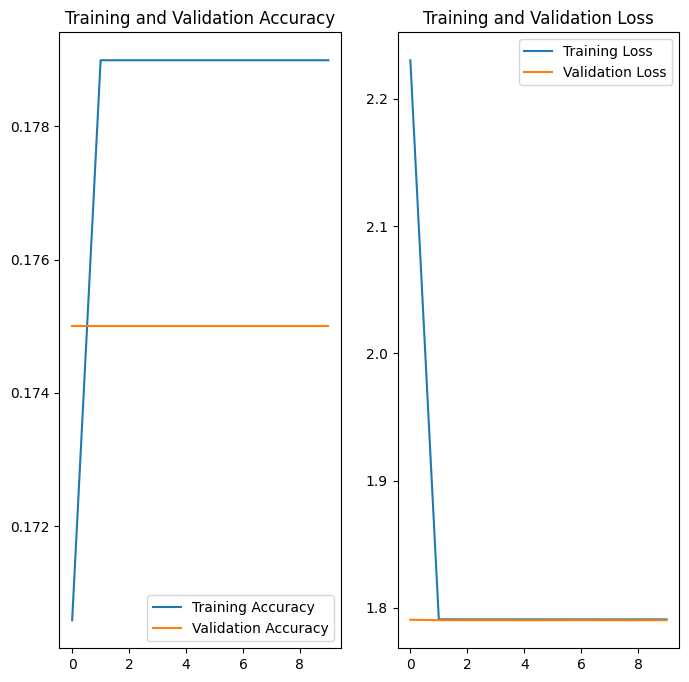

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_dense.history['accuracy']
val_acc = history_dense.history['val_accuracy']

loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observación:*** *el rendimiento del modelo es muy deficiente, lo que demuetra la incompatibilidad de una arquitectura de Red Neuronal con capas densas para resolver problemas de este tipo. Se omiten las predicciones para este tipo.*

# Modelo con Capas Convolucionales y Densas

## Definición y Entrenamiento

### Arquitectura

In [ ]:
def build_model_conv(input_shape, output_labels):
    print("Building model")
    # Definir la entrada
    i = Input(input_shape, dtype=tf.float32)

    # Preprocesamiento de imágenes
    x = Rescaling(1./255)(i)

    # Capas de aumentación de datos
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Capas convolucionales
    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    # Aplanar la entrada
    x = Flatten()(x)
    x = Dropout(0.3)(x)

    # Capa de salida
    x = Dense(output_labels, activation='softmax')(x)

    # Definir el modelo
    model = tf.keras.Model(inputs=i, outputs=x)
    print("Model done")
    return model

### Construcción

In [ ]:
model_conv = build_model_conv((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)
model_conv.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
Model done


### Resumen

In [ ]:
model_conv.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_translation_3 (Rand  (None, 150, 150, 3)       0         
 omTranslation)                                                  
                                                                 
 random_contrast_3 (RandomC  (None, 150, 150, 3)       0         
 ontrast)                                                  

### Entrenamiento

In [ ]:
print("Inicio del Entrenamiento\n-------------------------")

# CallBacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    "model-e{epoch:02d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

callbacks=[checkpoint_acc, reduce_lr, early_stopping]

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history_conv = model_conv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)
print("-------------------------\nFin del Entrenamiento")

Inicio del Entrenamiento
-------------------------
Epoch 1/10
439/439 [==============================] - 484s 1s/step - loss: 1.1356 - accuracy: 0.5368 - val_loss: 0.8603 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 2/10
439/439 [==============================] - 468s 1s/step - loss: 0.8625 - accuracy: 0.6669 - val_loss: 0.7400 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 3/10
439/439 [==============================] - 476s 1s/step - loss: 0.7615 - accuracy: 0.7118 - val_loss: 0.7084 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 4/10
439/439 [==============================] - 464s 1s/step - loss: 0.6899 - accuracy: 0.7424 - val_loss: 0.6615 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 5/10
439/439 [==============================] - 431s 983ms/step - loss: 0.6553 - accuracy: 0.7527 - val_loss: 0.6467 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 6/10
439/439 [==============================] - 481s 1s/step - loss: 0.6291 - accuracy: 0.7656 - val_loss: 0.5655 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 7/10

## Visualización de Métricas

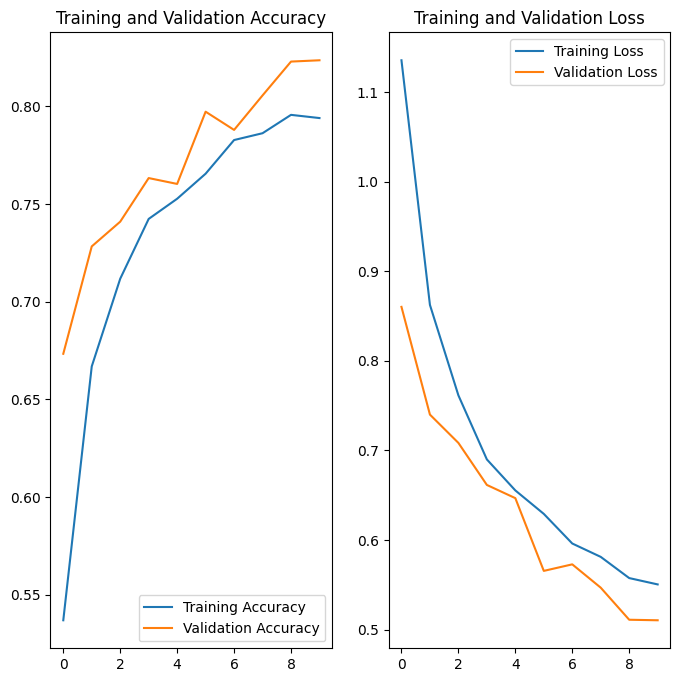

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_conv.history['accuracy']
val_acc = history_conv.history['val_accuracy']

loss = history_conv.history['loss']
val_loss = history_conv.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observación:*** *el dataset empleado para hacer predicciones no se encuentra etiquetado, por lo que se omiten los cálculos de las métricas de test y la matriz de confusión. La visualización de los resultados de las predicciones se encuentra en la sección siguiente.*

# Modelo con Bloques Residuales

## Definición y Entrenamiento

### Arquitectura

In [31]:
def ResidualBlock(filters, kernel_size):
    def f(x):
        x_skip = x
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = Activation("relu")(x)
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = Activation("relu")(x)
        if x.shape[-1] != x_skip.shape[-1]:
            x_skip = Conv2D(filters, (1, 1), padding='same')(x_skip)
        x = tf.keras.layers.Add()([x_skip, x])
        x = Activation("relu")(x)
        return x
    return f


def build_model_resnet(input_shape, output_labels):
    print("Building model")
    # Definir la entrada
    i = Input(input_shape, dtype=tf.float32)

    # Preprocesamiento de imágenes
    x = Rescaling(1./255)(i)

    # Capas de aumentación de datos
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Capas convolucionales con bloques residuales
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Activation("relu")(x)

    x = ResidualBlock(16, (3, 3))(x)
    x = MaxPooling2D((2, 2))(x)

    x = ResidualBlock(32, (3, 3))(x)
    x = MaxPooling2D((2, 2))(x)

    x = ResidualBlock(64, (3, 3))(x)
    x = MaxPooling2D((2, 2))(x)

    # Aplanar la entrada
    x = Flatten()(x)
    x = Dropout(0.25)(x)

    # Capa de salida
    x = Dense(output_labels, activation='softmax')(x)

    # Definir el modelo
    model = tf.keras.Model(inputs=i, outputs=x)
    print("Model done")
    return model

### Construcción

In [32]:
model_resnet = build_model_resnet((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)
model_resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
Model done


### Resumen

In [33]:
model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 150, 150, 3)          0         ['input_5[0][0]']             
                                                                                                  
 random_flip_4 (RandomFlip)  (None, 150, 150, 3)          0         ['rescaling_4[0][0]']         
                                                                                                  
 random_flip_5 (RandomFlip)  (None, 150, 150, 3)          0         ['random_flip_4[0][0]']       
                                                                                            

### Entrenamiento

In [34]:
print("Inicio del Entrenamiento\n-------------------------")

# CallBacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    "model-e{epoch:02d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

callbacks=[checkpoint_acc, reduce_lr, early_stopping]

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)
print("-------------------------\nFin del Entrenamiento")

Inicio del Entrenamiento
-------------------------
Epoch 1/30
439/439 [==============================] - 31s 62ms/step - loss: 1.0729 - accuracy: 0.5664 - val_loss: 0.8716 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 26s 59ms/step - loss: 0.8076 - accuracy: 0.6922 - val_loss: 0.7375 - val_accuracy: 0.7120 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 26s 60ms/step - loss: 0.7344 - accuracy: 0.7208 - val_loss: 0.6285 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 23s 52ms/step - loss: 0.6684 - accuracy: 0.7463 - val_loss: 0.7149 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 27s 61ms/step - loss: 0.6177 - accuracy: 0.7702 - val_loss: 0.5881 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - 26s 60ms/step - loss: 0.5857 - accuracy: 0.7805 - val_loss: 0.5244 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 7

## Visualización de Métricas

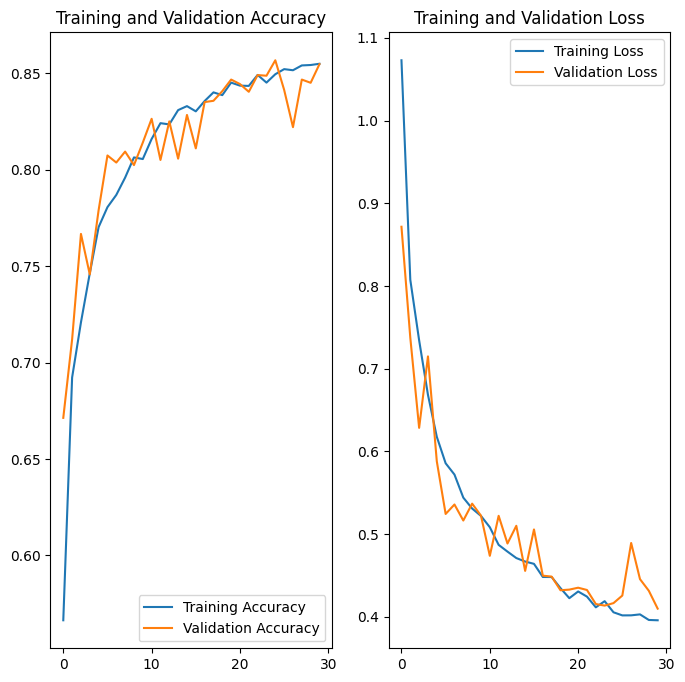

In [35]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observación:*** *el dataset empleado para hacer predicciones no se encuentra etiquetado, por lo que se omiten los cálculos de las métricas de test y la matriz de confusión. La visualización de los resultados de las predicciones se encuentra en la sección siguiente.*

# Modelo Convolucional con Transfer Learning

## Definición y entrenamiento

### Arquitectura

In [37]:
def build_model_tl(input_shape, num_classes):
    print("Building model")
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    print("Model done")
    return tf.keras.Model(i, x)

### Construcción

In [38]:
model_tl = build_model_tl((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)
model_tl.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
Model done


### Resumen

In [39]:
model_tl.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d_1 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_3 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 4057257 (15.48 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


### Entrenamiento

In [40]:
print("Inicio del Entrenamiento\n-------------------------")

# CallBacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    "model-e{epoch:02d}-loss{val_loss:.3f}-acc{val_accuracy:.3f}",
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, epsilon=1e-4, mode="min"
)

callbacks=[checkpoint_acc, reduce_lr, early_stopping]

# Número de épocas de entrenamiento
EPOCHS = 20
# Entrena el modelo
history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)
print("-------------------------\nFin del Entrenamiento")

Inicio del Entrenamiento
-------------------------
Epoch 1/20
439/439 [==============================] - 61s 122ms/step - loss: 0.5223 - accuracy: 0.8328 - val_loss: 0.3530 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 2/20
439/439 [==============================] - 48s 108ms/step - loss: 0.2730 - accuracy: 0.9052 - val_loss: 0.3347 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 3/20
439/439 [==============================] - 20s 45ms/step - loss: 0.2205 - accuracy: 0.9225 - val_loss: 0.3903 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 4/20
439/439 [==============================] - 46s 105ms/step - loss: 0.1991 - accuracy: 0.9284 - val_loss: 0.3343 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 5/20
439/439 [==============================] - 21s 48ms/step - loss: 0.1755 - accuracy: 0.9370 - val_loss: 0.3845 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 6/20
439/439 [==============================] - 19s 44ms/step - loss: 0.1594 - accuracy: 0.9416 - val_loss: 0.3491 - val_accuracy: 0.8940 - lr: 0.0010
Epoc

## Visualización de Métricas

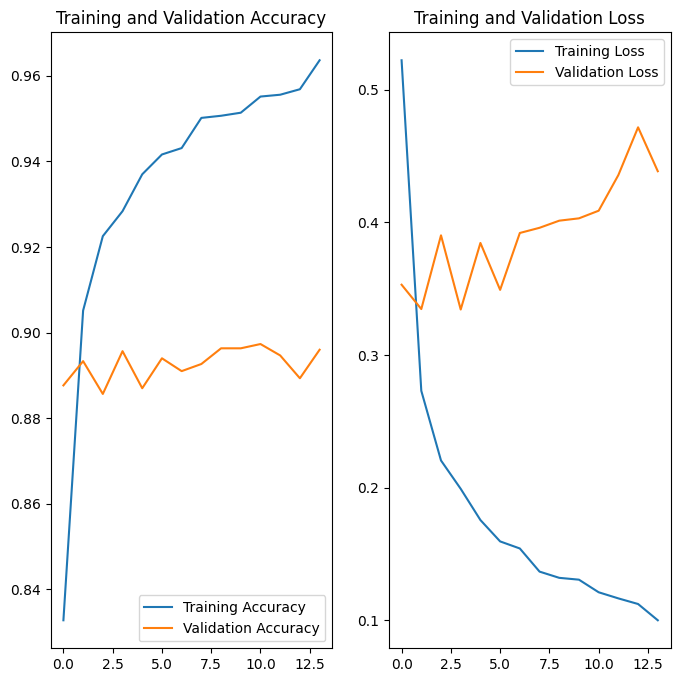

In [41]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

epochs_range = range(EPOCHS-6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Observación:*** *el dataset empleado para hacer predicciones no se encuentra etiquetado, por lo que se omiten los cálculos de las métricas de test y la matriz de confusión. La visualización de los resultados de las predicciones se encuentra en la sección siguiente.*

# Predicciones

*En cada una de las secciones siguientes se ilustra una muetra aleatoria de imágenes correspondiente al dataset de pruebas, separadas por el tipo de arquitectura empleada, y el resultado de efectuar las predicciones de la clase con cada modelos de redes convolucional.*

*Se hace notar que el dataset de test no tiene etiquetas, por lo que la evaluación de la efectividad de la clasificación queda delegada a la inspección visual.*

## Modelo con Capas Densas

In [ ]:
# Definir la cantidad de imágenes a mostrar
cant = 5

# Obtener una lista aleatoria de índices para seleccionar imágenes aleatorias del conjunto de datos
random_indices = random.sample(range(len(test_ds)), cant)

# Crear una figura para mostrar las imágenes
fig, axes = plt.subplots(1, cant, figsize=(15, 3))

# Iterar sobre los índices aleatorios y mostrar las imágenes correspondientes
for i, idx in enumerate(random_indices):
    # Obtener la imagen en el índice aleatorio
    image = test_ds.skip(idx).take(1)
    image = next(iter(image))

    # Realizar la predicción
    prediction_dense = model_dense.predict(tf.expand_dims(image, axis=0))
    predicted_class_index_dense = np.argmax(prediction_dense)
    predicted_class_dense = class_names[predicted_class_index_dense]

    # Mostrar la imagen y la predicción
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis('off')
    ax.set_title(f"Predicted: {predicted_class_dense}")

plt.tight_layout()
plt.show()

## Modelo con Capas Convolucionales

In [ ]:
# Definir la cantidad de imágenes a mostrar
cant = 5

# Obtener una lista aleatoria de índices para seleccionar imágenes aleatorias del conjunto de datos
random_indices = random.sample(range(len(test_ds)), cant)

# Crear una figura para mostrar las imágenes
fig, axes = plt.subplots(1, cant, figsize=(15, 3))

# Iterar sobre los índices aleatorios y mostrar las imágenes correspondientes
for i, idx in enumerate(random_indices):
    # Obtener la imagen en el índice aleatorio
    image = test_ds.skip(idx).take(1)
    image = next(iter(image))

    # Realizar la predicción
    prediction_conv = model_conv.predict(tf.expand_dims(image, axis=0))
    predicted_class_index_conv = np.argmax(prediction_conv)
    predicted_class_conv = class_names[predicted_class_index_conv]

    # Mostrar la imagen y la predicción
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis('off')
    ax.set_title(f"Predicted: {predicted_class_conv}")

plt.tight_layout()
plt.show()

## Modelo con Bloques Residuales

In [ ]:
# Definir la cantidad de imágenes a mostrar
cant = 5

# Obtener una lista aleatoria de índices para seleccionar imágenes aleatorias del conjunto de datos
random_indices = random.sample(range(len(test_ds)), cant)

# Crear una figura para mostrar las imágenes
fig, axes = plt.subplots(1, cant, figsize=(15, 3))

# Iterar sobre los índices aleatorios y mostrar las imágenes correspondientes
for i, idx in enumerate(random_indices):
    # Obtener la imagen en el índice aleatorio
    image = test_ds.skip(idx).take(1)
    image = next(iter(image))

    # Realizar la predicción
    prediction_resnet = model_resnet.predict(tf.expand_dims(image, axis=0))
    predicted_class_index_resnet = np.argmax(prediction_resnet)
    predicted_class_resnet = class_names[predicted_class_index_resnet]

    # Mostrar la imagen y la predicción
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis('off')
    ax.set_title(f"Predicted: {predicted_class_resnet}")

plt.tight_layout()
plt.show()

## Modelo Convolucional con Transfer Learning

### Salida (1 x N)

1/1 [==============================] - 0s 26ms/step


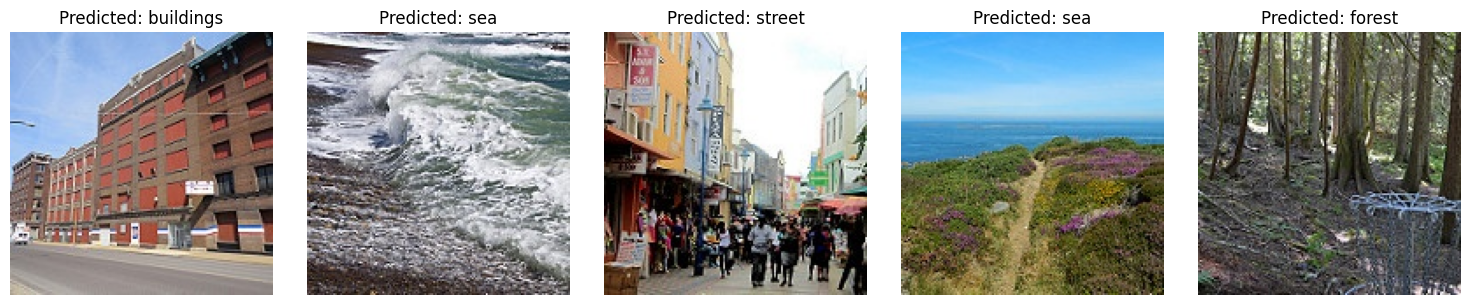

In [29]:
# Definir la cantidad de imágenes a mostrar
cant = 5

# Obtener una lista aleatoria de índices para seleccionar imágenes aleatorias del conjunto de datos
random_indices = random.sample(range(len(test_ds)), cant)

# Crear una figura para mostrar las imágenes
fig, axes = plt.subplots(1, cant, figsize=(15, 3))

# Iterar sobre los índices aleatorios y mostrar las imágenes correspondientes
for i, idx in enumerate(random_indices):
    # Obtener la imagen en el índice aleatorio
    image = test_ds.skip(idx).take(1)
    image = next(iter(image))

    # Realizar la predicción
    prediction_tl = model_tl.predict(tf.expand_dims(image, axis=0))
    predicted_class_inde_tl = np.argmax(prediction_tl)
    predicted_class_tl = class_names[predicted_class_index_tl]

    # Mostrar la imagen y la predicción
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis('off')
    ax.set_title(f"Predicted: {predicted_class_tl}")

plt.tight_layout()
plt.show()

### Salida (3 x N)

1/1 [==============================] - 0s 25ms/step


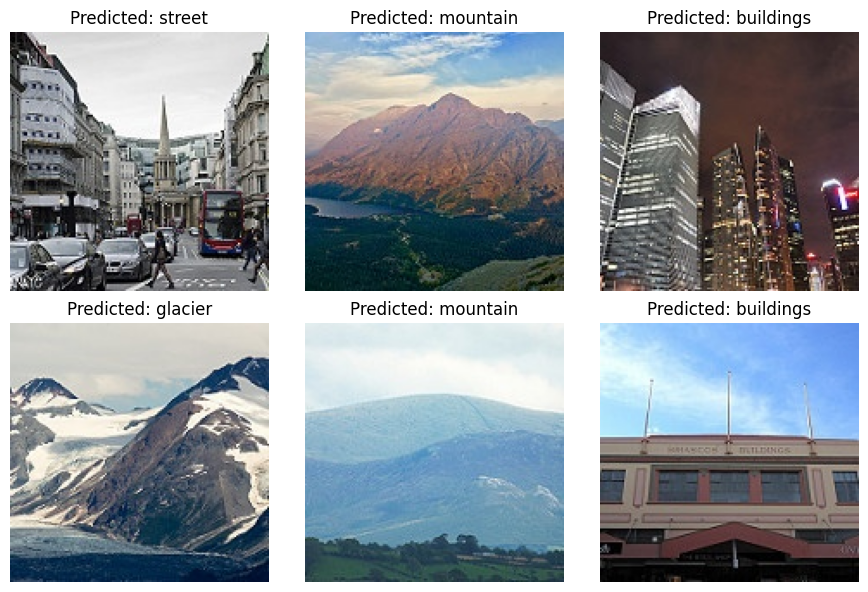

In [30]:
# Definir la cantidad de imágenes a mostrar
cant = 6
num_filas = (cant + 2) // 3  # Calcular el número de filas necesarias

# Obtener una lista aleatoria de índices para seleccionar imágenes aleatorias del conjunto de datos
random_indices = random.sample(range(len(test_ds)), cant)

# Crear una figura para mostrar las imágenes
fig, axes = plt.subplots(num_filas, 3, figsize=(9, 3 * num_filas))

# Iterar sobre los índices aleatorios y mostrar las imágenes correspondientes
for i, idx in enumerate(random_indices):
    # Obtener la posición de la subfigura en la matriz de visualización
    fila = i // 3
    columna = i % 3

    # Obtener la imagen en el índice aleatorio
    image = test_ds.skip(idx).take(1)
    image = next(iter(image))

    # Realizar la predicción
    prediction_tl = model_tl.predict(tf.expand_dims(image, axis=0))
    predicted_class_index_tl = np.argmax(prediction_tl)
    predicted_class_tl = class_names[predicted_class_index_tl]

    # Mostrar la imagen y la predicción
    ax = axes[fila, columna]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis('off')
    ax.set_title(f"Predicted: {predicted_class_tl}")

# Ajustar el espaciado de las subfiguras
plt.tight_layout()
plt.show()